In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from torchsummary import summary

In [2]:
###   Load data

transformation = transforms.Compose (
    [
        transforms.CenterCrop ((500, 500)),
        transforms.Resize (224),
        transforms.ToTensor (),
    ]
)

train_data = datasets.Flowers102 ("data", split = "train", download = True, transform = transformation)
validation_data = datasets.Flowers102 ("data", split = "val", download = True, transform = transformation)
test_data = datasets.Flowers102 ("data", split = "test", download = True, transform = transformation)

100%|██████████| 344862509/344862509 [00:12<00:00, 27324330.15it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 357598.61it/s]


100%|██████████| 14989/14989 [00:00<00:00, 11963543.80it/s]


In [3]:
###   Setup loader

phases = {
    'train': train_data,
    'valid': validation_data,
    'test': test_data
}

#   Parameters for loader
batch_size = 32

loader = {phase: DataLoader (dataset, batch_size = batch_size, shuffle = (phase == "train"))
    for phase, dataset in phases.items ()
}

In [4]:
###   Examine dataset

train_data[0][0].shape

torch.Size([3, 224, 224])

In [5]:
###   Visualising some of the dataset

def visualise (image, label):
    plt.figure ()
    plt.imshow (image)
    plt.title (str (label))
    plt.xticks ([])
    plt.yticks ([])

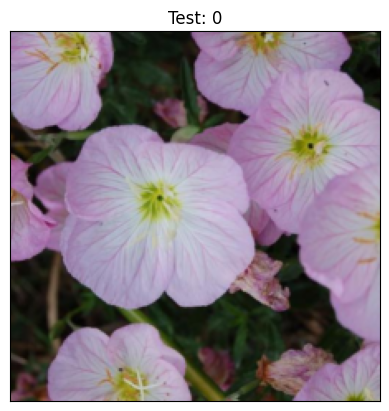

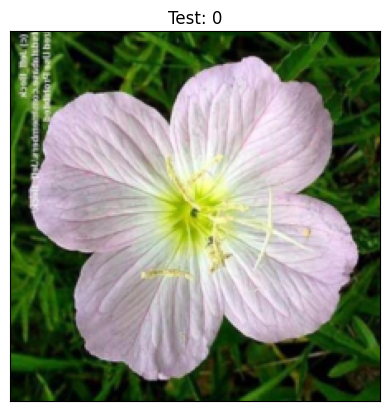

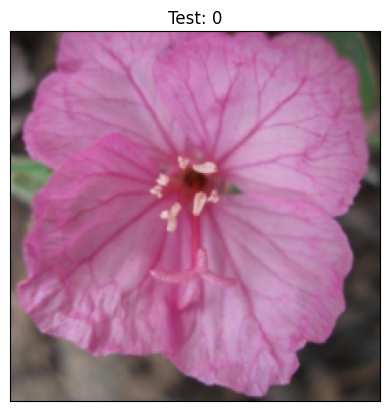

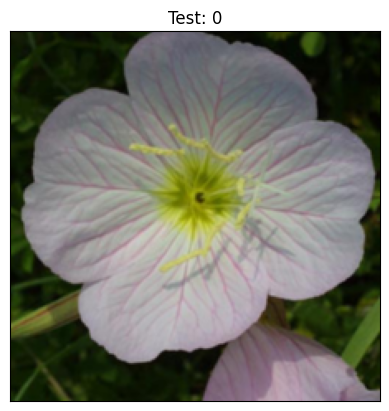

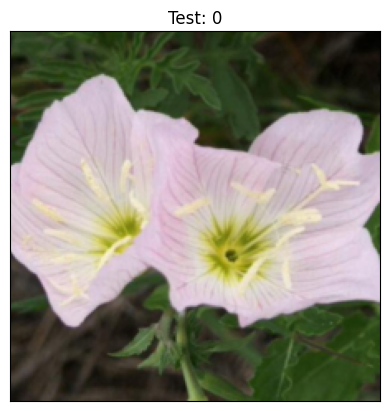

In [6]:
train_example = [train_data[i] for i in range (5)]

for image, label in train_example:
    image = torch.permute (image, (2, 1, 0)).numpy ()
    visualise (image, f'Test: {label}')

In [7]:
###   Create model

class Model (nn.Module):
    '''Class defining the neural network.

    Parameters:
    num_classes: the number of possible classifications for the model
    '''

    def __init__ (self, num_classes = 1000):
        super (Model, self).__init__ ()

        self.features = nn.Sequential (
            nn.Conv2d (3, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU (inplace = True),
            nn.MaxPool2d (kernel_size = 3, stride = 6),
            nn.Conv2d (32, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU (inplace = True),
            nn.MaxPool2d (kernel_size = 3)
        )

        self.flatten = nn.Flatten (start_dim = 1)

        self.classifier = nn.Sequential (
            nn.Linear (32 * 12 * 12, 512),
            nn.ReLU (),
            nn.Dropout (0.5),
            nn.Linear (512, num_classes)
        )

    def forward (self, x):
        x = self.features (x)
        x = self.flatten (x)
        x = self.classifier (x)
        return x

In [8]:
def model_summary (Model_class, num_classes = 1000, sample_input = (3, 224, 224)):

    model = Model_class (num_classes)

    summary (model, sample_input)

In [9]:
model_summary (Model, num_classes = 102)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3           [-1, 32, 37, 37]               0
            Conv2d-4           [-1, 32, 37, 37]           9,248
              ReLU-5           [-1, 32, 37, 37]               0
         MaxPool2d-6           [-1, 32, 12, 12]               0
           Flatten-7                 [-1, 4608]               0
            Linear-8                  [-1, 512]       2,359,808
              ReLU-9                  [-1, 512]               0
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 102]          52,326
Total params: 2,422,278
Trainable params: 2,422,278
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forw

In [10]:
###   Instantiate model

model = Model (num_classes = 102)

In [11]:
###   Model parameters

learning_rate = 0.01
momentum = 0.9   #   optimizer momentum

device = "cuda" if torch.cuda.is_available () else "cpu"

criterion = nn.CrossEntropyLoss ()
optimizer = torch.optim.SGD (model.parameters (), lr = learning_rate, momentum = momentum)

In [13]:
###   Model evaluation function

def evaluate (model_, loader, device, criterion, mode = "valid"):
    '''Function for running model evaluation.'''

    model_.eval ()

    total = 0
    total_correct = 0
    total_loss = 0

    for i, (images, labels) in enumerate (loader[mode]):

        images = images.to (device)
        labels = labels.to (device)

        with torch.no_grad ():
            outputs = model_ (images)
            loss = criterion (outputs, labels)
            total_loss += loss.item () * images.size (0)
            total += images.size (0)
            _, predictions = outputs.max (1)
            total_correct += (labels == predictions).sum ()

    accuracy = total_correct / total
    loss = total_loss / total

    msg = f"Loss({loss:6.4f}) Accuracy({accuracy:6.4f})"

    if mode == "valid":
        print (f"{mode}: " + msg)
    else:
        print (f"{mode}: " + msg)

In [14]:
###   Train model

model = model.to (device)

num_epochs = 10

for epoch in range (num_epochs):
    model.train ()

    total = 0
    total_correct = 0
    total_loss = 0

    for i, (images, labels) in enumerate (loader['train']):
        images = images.to (device)
        labels = labels.to (device)

        optimizer.zero_grad ()

        outputs = model (images)

        loss = criterion (outputs, labels)
        loss.backward ()
        optimizer.step ()

        total += images.size (0)

        _, predictions = outputs.max (1)

        total_correct += (predictions == labels).sum ()
        total_loss += loss.item () * images.size (0)

    accuracy = total_correct / total
    loss = total_loss / total

    print (f"Epoch {epoch + 1}")
    print (f"Train: Loss({loss:6.4f}) Accuracy({accuracy:6.4f})")

    evaluate (model, loader, device, criterion, mode = 'valid')

Epoch 1
Train: Loss(4.6289) Accuracy(0.0039)
valid: Loss(4.6208) Accuracy(0.0078)
Epoch 2
Train: Loss(4.6210) Accuracy(0.0078)
valid: Loss(4.6141) Accuracy(0.0088)
Epoch 3
Train: Loss(4.6087) Accuracy(0.0167)
valid: Loss(4.5875) Accuracy(0.0294)
Epoch 4
Train: Loss(4.5463) Accuracy(0.0255)
valid: Loss(4.4452) Accuracy(0.0284)
Epoch 5
Train: Loss(4.3394) Accuracy(0.0353)
valid: Loss(4.2433) Accuracy(0.0275)
Epoch 6
Train: Loss(4.1821) Accuracy(0.0441)
valid: Loss(4.1163) Accuracy(0.0520)
Epoch 7
Train: Loss(4.0218) Accuracy(0.0755)
valid: Loss(3.9491) Accuracy(0.0843)
Epoch 8
Train: Loss(3.7838) Accuracy(0.0990)
valid: Loss(3.7588) Accuracy(0.1078)
Epoch 9
Train: Loss(3.5297) Accuracy(0.1431)
valid: Loss(3.6502) Accuracy(0.1225)
Epoch 10
Train: Loss(3.3723) Accuracy(0.1647)
valid: Loss(3.4975) Accuracy(0.1667)
